# Bayesian Tree Inference

## daft

http://daft-pgm.org/


install daft by 
1. downloading from https://github.com/dfm/daft
1. activate the conda environment where you want this
1. `python setup.py install`



## Linear regression

Taken from http://people.duke.edu/~ccc14/sta-663-2017/19A_PyMC3.html


How to estimate regression parameters using a simple linear model

$$y\approx ax+b$$

We can restate the linear model
$$y= ax+b + \epsilon$$

as sampling from a probability distribution
$$y \sim {\cal N}(ax+b,\sigma^2)$$

Now we can use pymc to estimate the parameters $a$, $b$ and $\sigma$. We will assume the following priors

$$a\sim {\cal N}(0,100)$$
$$b\sim {\cal N}(0,100)$$
$$\sigma\sim |{\cal N}(0,1)|$$



In [1]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import daft
# import networkx as nx

import theano.tensor as T
from theano.compile.ops import as_op
import theano
theano.config.warn.round=False

%matplotlib inline

import theano.tensor as T
from theano.compile.ops import as_op
import theano


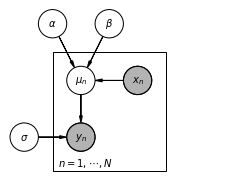

In [2]:
# Instantiate the PGM.
pgm = daft.PGM(shape=[4.0, 3.0], origin=[-0.3, -0.7])

# Hierarchical parameters.
pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 2))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 2))
pgm.add_node(daft.Node("sigma", r"$\sigma$", 0, 0))

# Deterministic variable.
pgm.add_node(daft.Node("mu", r"$\mu_n$", 1, 1))

# Data.
pgm.add_node(daft.Node("x", r"$x_n$", 2, 1, observed=True))
pgm.add_node(daft.Node("y", r"$y_n$", 1, 0, observed=True))

# Add in the edges.
pgm.add_edge("alpha", "mu")
pgm.add_edge("beta", "mu")
pgm.add_edge("x", "mu")
pgm.add_edge("mu", "y")
pgm.add_edge("sigma", "y")

# And a plate.
pgm.add_plate(daft.Plate([0.5, -0.5, 2, 2], label=r"$n = 1, \cdots, N$",
    shift=-0.1))

# Render and save.
pgm.render()
pgm.figure.savefig("lm.pdf")

Setting up  and fitting the linear model. With only 21 points the data set is quite small, and the fit cannot be very good.


In [3]:
# observed data
np.random.seed(123)
n = 21
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)

In [4]:
niter = 20000
with pm.Model() as linreg:
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=100)
    sigma = pm.HalfNormal('sigma', sd=1)

    y_est = a*x + b
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)

    trace = pm.sample(niter, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82000/82000 [00:43<00:00, 1886.84draws/s]


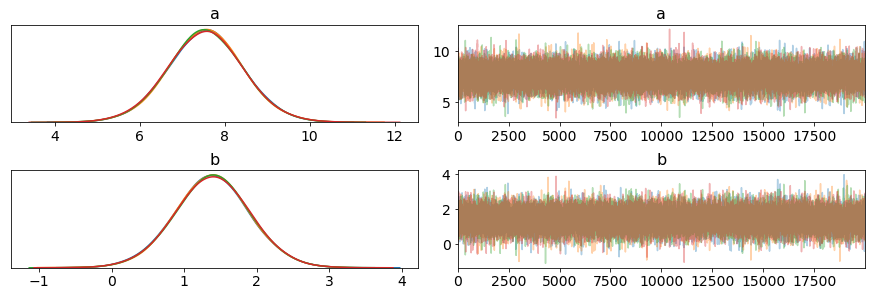

In [5]:
t = trace[niter//2:]
pm.traceplot(trace, var_names=['a', 'b'])
pass

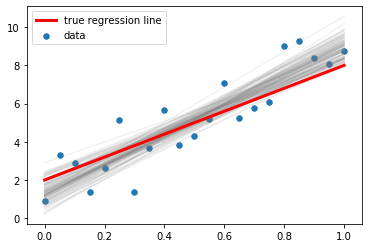

In [6]:
plt.scatter(x, y, s=30, label='data')
for a_, b_ in zip(t['a'][-100:], t['b'][-100:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
plt.plot(x, _a*x + _b, label='true regression line', lw=3., c='red')
plt.legend(loc='best')
pass

In [7]:
print(np.mean(t['a']))
print(np.mean(t['b']))


7.5311484
1.3799767


Posterior predictive checks

In [8]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=linreg, size=11)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 946.97it/s]


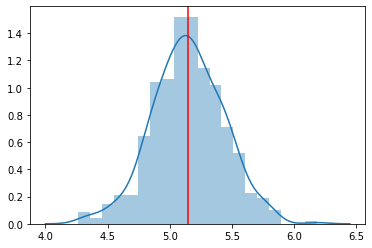

In [9]:
sns.distplot([np.mean(n) for n in ppc['y']], kde=True)
plt.axvline(np.mean(y), color='red')
pass

## Bayesian Network Models in PyMC3 and NetworkX

taken from https://gist.github.com/tbsexton/1349864212b25cce91dbe5e336d794b4

Taken from PMML 4.3

http://dmg.org/pmml/v4-3/BayesianNetwork.html


We start with a simple network having several continuous and several discrete (categorical) distributions. We have to define the conditional probabilities for each case in the categorical nodes. 

A scoring example with PMML/BN is provided here for illustration. An example BN is shown below, along with the prior probabilities for the nodes. The BN in the figure below has a combination of continuous and discrete nodes. D1, D2, D3, and D4 are discrete nodes, while C1, C2, C3, and C4 are continuous nodes. The prior probabilities and discrete and continuous conditional probability tables are listed below. In the Bayesian network shown below, let us say that new observations on two variables D4, C4 are available, for example, D4 = 0 and C4 = 7. This new information will be used to estimate unobserved variables, i.e., D1, D2, D3, C1, C2, and C3.


<img src="http://dmg.org/pmml/v4-3/BNExampleModel.png" alt="alt text" width="400" height="400" align="left">


------------------------------------------
$D_1$   | Probability
-----|-------
0	 |    0.3
1    |	  0.7

----------------------------------------------
$D_2$| Probability
----|----
0	| 0.6
1	| 0.3
2	| 0.1

-------------------------------------------
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $D_1$=0  | $D_1$=1
--------------|----------------------|----
$P(C_1|D_1)$ |$\mathcal{N}$(10,2)|$\mathcal{N}$(14,2)|

-------------------------------------------------------
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp;| $D_2$=0	| $D_2$=1  | $D_2$=2
-----|------------|----------------------|----
$P(C_2|D_2)$ |	$\mathcal{N}$(6,2)|	$\mathcal{N}$(8,1)| $\mathcal{N}$(14,1)|

------------------------------------------------
$$P(C_4 | C_2) = \mathcal{N}(0.1 C_2^2 + 0.6C_2 + 1, 2)$$

--------------------------------------------------------
<div style="width:50px" ></div>|<div style="width:80px" > $D_3$=0</div>| <div style="width:80px" >$D_3$=1</div>
------------|----------------------|---------
$ P(C_3|C_2)  $|$\mathcal{N}(0.15C_2^2,2)$|$\mathcal{N}(0.15C_2,1)$

---------------------------
<table style="border-style: solid; border-width: 1px">
  <tr style="border-style: solid; border-width: 1px">
    <th><div style="width:50px" style="border-style: solid; border-width: 1px"></div></th>
    <th colspan="3" style="border-style: solid; border-width: 1px"><div style="width:50px text-align:center" >$D_1=0$</div></th>
    <th colspan="3" style="border-style: solid; border-width: 1px"><div style="width:50px text-align:center">$D_1=1$</div></th>
  </tr>
    
  <tr>
    <td style="border-style: solid; border-width: 1px"><div style="width:50px" >$D_3$</div></td>
    <td style="border-style: solid; border-width: 1px"><div style="width:50px" >$D_2=0$</div></td>
    <td style="border-style: solid; border-width: 1px"><div style="width:50px" >$D_2=1$</div></td>
    <td style="border-style: solid; border-width: 1px"><div style="width:50px" >$D_2=2$</div></td>
    <td style="border-style: solid; border-width: 1px"><div style="width:50px" >$D_2=0$</div></td>
    <td style="border-style: solid; border-width: 1px"><div style="width:50px" >$D_2=1$</div></td>
    <td style="border-style: solid; border-width: 1px"><div style="width:50px" >$D_2=2$</div></td>
  </tr>
   <tr>
    <td style="border-style: solid; border-width: 1px">0</td>
    <td style="border-style: solid; border-width: 1px">0.1</td>
    <td style="border-style: solid; border-width: 1px">0.3</td>
    <td style="border-style: solid; border-width: 1px">0.4</td>
    <td style="border-style: solid; border-width: 1px">0.6</td>
    <td style="border-style: solid; border-width: 1px">0.9</td>
    <td style="border-style: solid; border-width: 1px">0.9</td>
  </tr>
  <tr>
    <td style="border-style: solid; border-width: 1px">1</td>
    <td style="border-style: solid; border-width: 1px">0.9</td>
    <td style="border-style: solid; border-width: 1px">0.7</td>
    <td style="border-style: solid; border-width: 1px">0.6</td>
    <td style="border-style: solid; border-width: 1px">0.4</td>
    <td style="border-style: solid; border-width: 1px">0.2</td>
    <td style="border-style: solid; border-width: 1px">0.1</td>
  </tr>
   
</table>

    
---------------------------
<table style="border-style: solid; border-width: 1px">
  <tr style="border-style: solid; border-width: 1px">
    <th><div style="width:50px" style="border-style: solid; border-width: 1px"></div></th>
    <th colspan="3" style="border-style: solid; border-width: 1px"><div style="width:50px text-align:center" >$D_3=0$</div></th>
    <th colspan="3" style="border-style: solid; border-width: 1px"><div style="width:50px text-align:center">$D_3=1$</div></th>
  </tr>
    
  <tr>
    <td style="border-style: solid; border-width: 1px"><div style="width:50px" >$D_4$</div></td>
    <td style="border-style: solid; border-width: 1px"><div style="width:90px" >$C_3<9$</div></td>
    <td style="border-style: solid; border-width: 1px"><div style="width:90px" >$9<C_3<11$</div></td>
    <td style="border-style: solid; border-width: 1px"><div style="width:90px" >$11<C_3$</div></td>
    <td style="border-style: solid; border-width: 1px"><div style="width:90px" >$C_3<9$</div></td>
    <td style="border-style: solid; border-width: 1px"><div style="width:90px" >$9<C_3<11$</div></td>
    <td style="border-style: solid; border-width: 1px"><div style="width:90px" >$11<C_3$</div></td>
  </tr>
   <tr>
    <td style="border-style: solid; border-width: 1px">0</td>
    <td style="border-style: solid; border-width: 1px">0.4</td>
    <td style="border-style: solid; border-width: 1px">0.3</td>
    <td style="border-style: solid; border-width: 1px">0.6</td>
    <td style="border-style: solid; border-width: 1px">0.4</td>
    <td style="border-style: solid; border-width: 1px">0.1</td>
    <td style="border-style: solid; border-width: 1px">0.3</td>
  </tr>
  <tr>
    <td style="border-style: solid; border-width: 1px">1</td>
    <td style="border-style: solid; border-width: 1px">0.6</td>
    <td style="border-style: solid; border-width: 1px">0.7</td>
    <td style="border-style: solid; border-width: 1px">0.4</td>
    <td style="border-style: solid; border-width: 1px">0.6</td>
    <td style="border-style: solid; border-width: 1px">0.9</td>
    <td style="border-style: solid; border-width: 1px">0.7</td>
  </tr>
   
</table>

------------------------

Let $N_\textrm{obs}$,$\overline{N}_\textrm{obs}$ and $D$ denote the set of observed, unobserved variables and available data, respectively. Using the Bayes theorem, the updated (posterior) probability distributions of the unobserved variables can be estimated as

\begin{equation}
P(\overline{N}_\textrm{obs} | N_\textrm{obs} = D) \propto P(N_\textrm{obs} = D |\overline{N}_\textrm{obs}) P(\overline{N}_\textrm{obs})\nonumber
\end{equation}

In this scoring example, $D_4$, $C_4$ are observed variables (aka inputs). Given the values of $D_4$ = 0, and $C_4$ = 7, the rest of the variables can be inferred using the Bayes theorem as:

\begin{eqnarray}
    &&P(D_1,D_2,D_3,C_1,C_2,C_3|D_4=0,C_4=7 )\propto \nonumber\\
    &&\;\;\;\;\;\;P(D_4=0,C_4=7 | D_1,D_2,D_3,C_1,C_2,C_3) P(D_1,D_2,D_3,C_1,C_2,C_3)
    \nonumber
\end{eqnarray}


Solving the above expression can be computationally expensive; therefore, approximate methods such as Markov Chain Monte Carlo (MCMC) methods are used to obtain posterior distributions of unobserved variables. Note that MCMC are a class of algorithms, not a single algorithm. For example, within the MCMC class of algorithms, we can use the Metropolis-Hastings algorithm in the scoring example to generate samples from the joint posterior distribution. Since the method is based on generation of samples, it is possible that the results are not exactly the same in different executions. All MCMC class of algorithms are stochastic. However, there would not be a drastic variation in the results from multiple executions.

Using the Metropolis-Hastings algorithm, samples from the joint posterior distribution can be obtained and hence marginal distributions can be constructed. For categorical variables, $D_1$, $D_2$, and $D_3$, the change in the probabilities of each of the states due to the new information is given below.

                Prior   Posterior
    D1 =   0     0.     0.316
    D1 =   1     0.7    0.683

            Prior    Posterior
    D2 = 0   0.6     0.847
    D2 = 1   0.3     0.153
    D2 = 2   0.3     0

              Prior    Posterior
    D3 = 0   0.535     0.437
    D3 = 1   0.465     0.563

Similarly, for continuous variables $C_1$, $C_2$, and $C_3$, their entire prior and posterior probability distributions can be constructed. Along the distributions, their means and variances, shown below, are obtained.

![images/bayesInf-01.PNG](images/bayesInf-01.PNG)

![images/bayesInf-02.PNG](images/bayesInf-02.PNG)

![images/bayesInf-03.PNG](images/bayesInf-03.PNG)



Define the model:

In [10]:
d1_prob = np.array([0.3,0.7])  # 2 choices
d2_prob = np.array([0.6,0.3,0.1])  # 3 choices
d3_prob = np.array([[[0.1, 0.9],  # (2x3)x2 choices
                     [0.3, 0.7], 
                     [0.4, 0.6]], 
                    [[0.6, 0.4], 
                     [0.8, 0.2],
                     [0.9, 0.1]]])
d4_prob = np.array([[[0.4, 0.6],  # (2x3)x2 choices
                     [0.6, 0.4],
                     [0.3, 0.7]],
                    [[0.4, 0.6], 
                     [0.3, 0.7],
                     [0.1, 0.9]]])

c1_mu, c1_sd = np.array([[10, 14],  # 2 choices inherit
                         [2 , 2 ]])
c2_mu, c2_sd = np.array([[6, 8, 14],  # 3 choices inherit
                         [2, 1, 1 ]])


## Standard Approach in PyMC3
First we will build up the network using variable instantiation for each node. The "edges" here are really just indications that the distribution parameters are conditional upon the node's parents. 

I haven't been able to quite figure out a fast way of getting the inequality conditionals to work in Theano without using an ugly "switch" statement (node `C3`'s discretization for `C4`'s conditions). But, this works faster in Theano than a long python if-else block for now. 

Additionally, it's possible to write the combination of distributions into a continuous node in terms of a `NormalMixture()`, where the discrete parents are drawn from a `Dirichlet()` prior. Technically possible, but causes an inexplicable 
```
python.exe has stopped working
``` 
on my system (and python crashes on Linux, too), so maybe that will work out eventually as updates are rolled out. 

In [11]:
with pm.Model() as model:
    
    D1 = pm.Categorical('D1',p=d1_prob)
    D2 = pm.Categorical('D2',p=d2_prob)
    
    C1 = pm.Normal('C1',mu = 10 + 4*D1, tau = (1./2)**2)
    
    C2 = pm.Normal('C2',mu=6+2*(D2**2), tau=1)
    
    D3_prob = theano.shared(d3_prob)  # make numpy-->theano
    D3_0 = D3_prob[D1, D2]  # select the prob array that "happened" thanks to parents
    D3 = pm.Categorical('D3',p=D3_0)

    C3 = pm.Normal('C3',mu = (0.15*(C2**2)*(1-D3) + 1.5*C2*D3), tau=(1./(2-D3))**2)
    C4 = pm.Normal('C4',mu = 0.1*C2**2 + 0.6*C2+1, tau = 0.25, observed = [7])
    
    C3_0 = T.switch(T.lt(C3,9), 0, 
                   T.switch(T.gt(C3, 9) & T.lt(C3,11), 1, 2))  # ugly (and hard to generalize)

    D4_prob = theano.shared(d4_prob)  # make numpy-->theano   
    D4_0 = D4_prob[D3, C3_0]  # select the prob array that "happened" thanks to parents
        
    D4 = pm.Categorical('D4', p=D4_0, observed=[0])



In [12]:
# Create MCMC object
with model:
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [D1, D3]
>CategoricalGibbsMetropolis: [D2]
>NUTS: [C3, C2, C1]
Sampling 4 chains: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42000/42000 [00:24<00:00, 1697.59draws/s]
The number of effective samples is smaller than 25% for some parameters.


### Results
PyMC3 automatically assigned the super-efficient NUTS sampler where possible, and various versions of Metropolis to the rest of the nodes. Lets see how well our results compare to the ones listed in the [PMML example](http://dmg.org/pmml/v4-3/BayesianNetwork.html):

         mean        sd  mc_error   hpd_2.5   hpd_97.5         n_eff      Rhat
C1  12.894672  2.683002  0.029736  7.450693  17.757132   9224.105520  1.000161
C2   5.725239  0.797435  0.005942  4.186211   7.363812  14073.915539  0.999978
C3   6.755981  2.561763  0.031599  1.706975  11.002370   8611.930527  1.000265


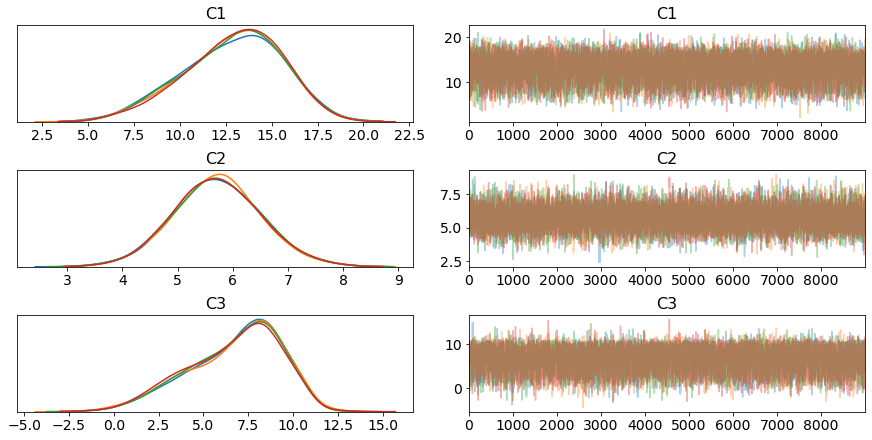

In [13]:
print(pm.summary(trace, var_names=['C1', 'C2', 'C3'], start=1000))
pm.traceplot(trace[1000:], var_names=['C1', 'C2', 'C3']);

## Note

For my purpose, the above is sufficient, where the network is fixed by initial design. 

Thurston Sexton (the author of the above) went further:
Let's do something a bit more sophisticated. Eventually, it would be nice to create a PyMC3 BayesNet on the fly, reading in a specification (like PMML, for example!) and generating/running the theano model. The 'pythonic' way to do programmatic variable instantiation is to use a dictionary...and one of my other favorite packages is essentially a package for graphs built on dicts!

Go study his gist if you want more information. My my own need, this is where I stop.

